In [218]:
import os
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import copy 
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

# 한글깨짐 해결
plt.rcParams["font.family"] = "Malgun Gothic"
# 마이너스 깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False

# 경고 메세지 삭제
warnings.filterwarnings('ignore')
os.chdir('C:/Users/min/Desktop/code/data/bigcontest')


#### 참고 페이지
#### https://www.kaggle.com/datacog314/tutorial-machine-learning-interpretability

In [219]:
data = pd.read_csv('AFSNT_weather_7.csv', encoding='euc-kr')
df = copy(data)
data1 = pd.read_csv('AFSNT_DLY.csv', encoding='euc-kr', parse_dates=['SDT'])

In [220]:
# 취사선택1)STTATT 삭제, STTATT 때문에 예측률이 1이 됨
data = data.drop(['REG','STTATT'], axis=1)


# 취사선택2)STTATT 남겨둠
# data = data.drop(['REG',], axis=1)

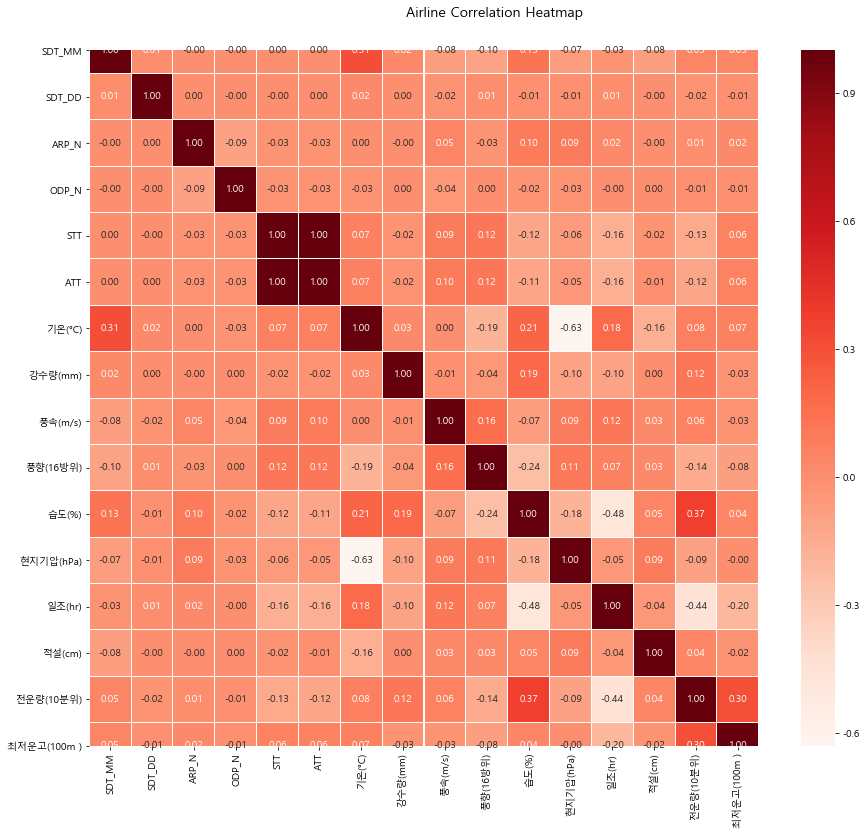

In [221]:
# for visualizing correlations
f, ax = plt.subplots(figsize=(15, 12))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Airline Correlation Heatmap', fontsize=14)

### 전처리

In [222]:
# 라벨링

from sklearn.preprocessing import LabelEncoder
 
# encode class values as integers
encoder = LabelEncoder()

encoder.fit(data['FLO'])
data['FLO'] = encoder.transform(data['FLO'])
encoder.fit(data['FLT'])
data['FLT'] = encoder.transform(data['FLT'])
encoder.fit(data['SDT_DY'])
data['SDT_DY'] = encoder.transform(data['SDT_DY'])
encoder.fit(data['AOD'])
data['AOD'] = encoder.transform(data['AOD'])
encoder.fit(data['IRR'])
data['IRR'] = encoder.transform(data['IRR'])
encoder.fit(data['DLY'])
data['DLY'] = encoder.transform(data['DLY'])

In [223]:
# X, y 정의

y= data['DLY']
X =data.drop(['DLY'], axis=1)
xx= copy(X)

In [237]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)
"""
X_test = X_test.values
y_test = y_test.values
"""
X_train.shape, X_test.shape

((734587, 21), (244863, 21))

## 1. Without Oversampling SMOTE
### 오버샘플링 하면 array로 형변환 되는데 pdp_plot에는 DataFrame 형태로 넣어야되서요.. 다시 데이터프레임으로 변환해서 넣으면 XGBoost가 실행히 안되네요.

In [238]:
# ML
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=33, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [240]:
# prediction
xgb_predictions = xgb.predict(X_test)

In [241]:
evaluation_scores(y_test, xgb_predictions, target_names=['Normal', 'Delay'])

Accuracy: 0.9113
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

      Normal       0.91      1.00      0.95    215179
       Delay       0.99      0.27      0.42     29684

   micro avg       0.91      0.91      0.91    244863
   macro avg       0.95      0.63      0.69    244863
weighted avg       0.92      0.91      0.89    244863

------------------------------------------------------------
Confusion matrix:

          Predicted:      
                   0     1
Actual: 0     215117    62
        1      21667  8017


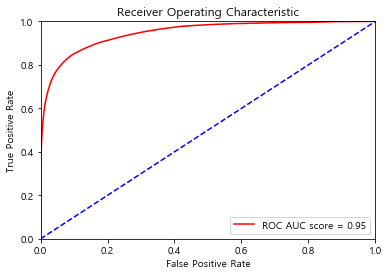

In [242]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Features importance 해석 방법
To interpret a model, we basically need to know :

which features are the most important in the model
1. the effect of each feature on a particular prediction
2. the effects of each feature over a large number of predictions
3. Native global feature importance calculations that come with XGBoostare are based on the following parameters :

Feature 
1. Weights: based on the number of times a feature appears in a tree across the ensemble of trees
2. Coverage: the average coverage (number of samples affected) of splits which use the feature
3. Gain: the average gain of splits which use the feature

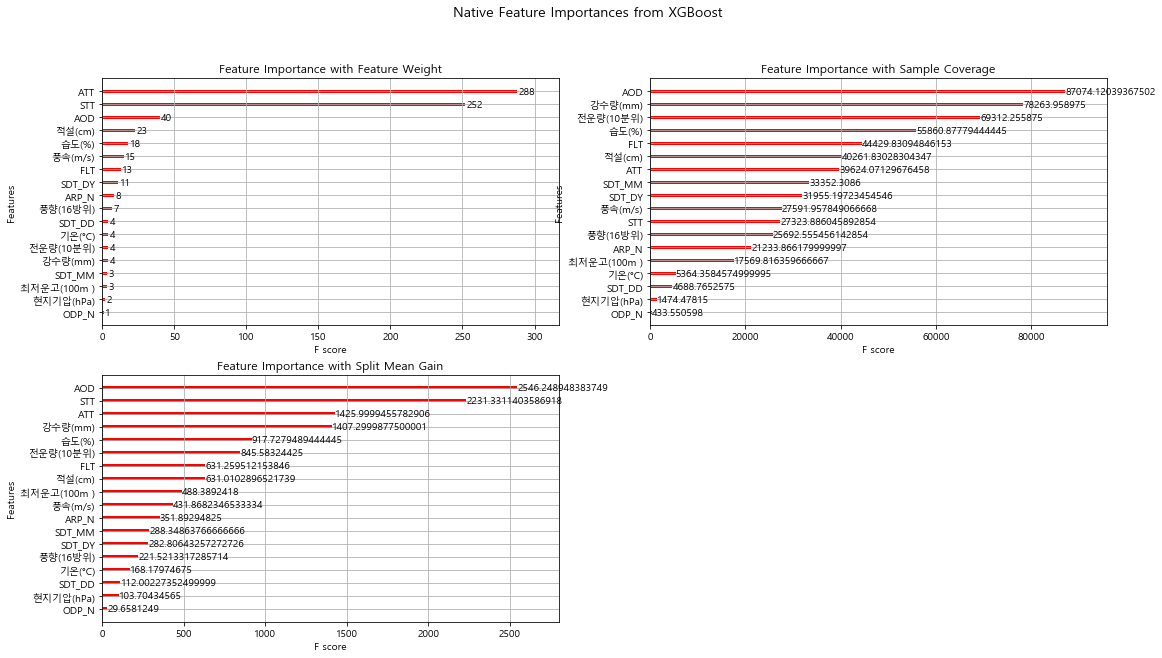

In [243]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

In [244]:
# feature importance
eli5.show_weights(xgb.get_booster())

Weight,Feature
0.1942,AOD
0.1701,STT
0.1087,ATT
0.1073,강수량(mm)
0.0700,습도(%)
0.0645,전운량(10분위)
0.0481,FLT
0.0481,적설(cm)
0.0372,최저운고(100m )
0.0329,풍속(m/s)


In [247]:
# 0이라고 예측할 경우
# 가장 중요한 요소는 AOD,ATT,FLT 3가지로 판단됨
print('Reference:', y_test.iloc[0])
print('Predicted:', xgb_predictions[0])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[0], 
                     feature_names=list(X.columns), show_feature_values=True)

Reference: 0
Predicted: 0


In [248]:
# 1이라고 예측할 경우
# 가장 중요한 요소는 AOD,ATT,FLT 3가지로 판단됨
print('Reference:', y_test.iloc[13])
print('Predicted:', xgb_predictions[13])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[13], 
                     feature_names=list(X.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In [249]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

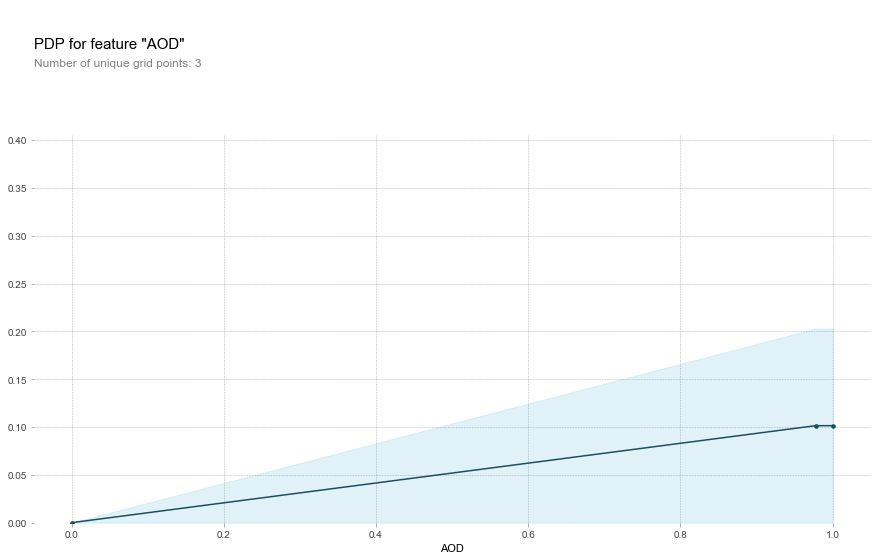

In [250]:
# PDP Plot
plot_pdp(xgb, X_train_df, 'AOD')

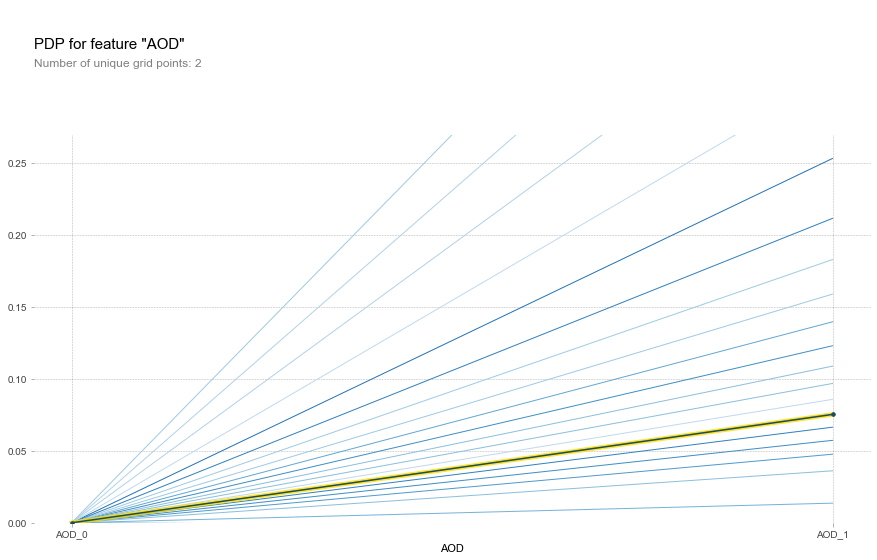

MemoryError: 

In [251]:
# ICE Plot
plot_pdp(xgb, X_train, 'AOD', cluster_flag=True, nb_clusters=24, lines_flag=True)

features_to_plot = ['ATT', 'STT']
features_list = list(X.columns)

inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

# we use plot_type='grid' as the default and better option 'contour' has a bug which is being corrected
# cf. https://github.com/SauceCat/PDPbox/issues/40

plt.show()

## 2. Oversampling SMOTE

In [194]:
# code: https://mkjjo.github.io/python/2019/01/04/smote_duplicate.html



print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}\n'.format(y_train.shape))

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {}\n".format(sum(y_train==0)))

# 모델설정
sm = SMOTE(ratio='auto', kind='regular')

# train데이터를 넣어 복제함
X_resample, y_resample = sm.fit_sample(X_train,list(y_train))

print('After OverSampling, the shape of X_resample: {}'.format(X_resample.shape))
print('After OverSampling, the shape of y_resample: {} \n'.format(y_resample.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resample==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resample==0)))


Before OverSampling, the shape of X_train: (734587, 21)
Before OverSampling, the shape of y_train: (734587,)

Before OverSampling, counts of label '1': 89253
Before OverSampling, counts of label '0': 645334

After OverSampling, the shape of X_train: (1290668, 21)
After OverSampling, the shape of y_train: (1290668,) 

After OverSampling, counts of label '1': 645334
After OverSampling, counts of label '0': 645334


In [195]:
"""
# X_train, y_train 데이터프레임 형태로 만들기

X_train = pd.DataFrame(X_train,columns = X.columns.tolist())
y_train = pd.DataFrame(y_train,columns = ['DLY'])

X_test = pd.DataFrame(X_test, columns = X.columns.tolist())
y_test = y_train = pd.DataFrame(y_test,columns = ['DLY'])
"""

"\n# X_train, y_train 데이터프레임 형태로 만들기\n\nX_train = pd.DataFrame(X_train,columns = X.columns.tolist())\ny_train = pd.DataFrame(y_train,columns = ['DLY'])\n\nX_test = pd.DataFrame(X_test, columns = X.columns.tolist())\ny_test = y_train = pd.DataFrame(y_test,columns = ['DLY'])\n"

In [196]:
# ML
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_resample, y_resample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=33, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [197]:
# prediction
xgb_predictions = xgb.predict(X_test)

In [198]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)

In [199]:
evaluation_scores(y_test, xgb_predictions, target_names=['Normal', 'Delay'])

Accuracy: 0.8814
------------------------------------------------------------
classification report:

               precision    recall  f1-score   support

      Normal       0.90      0.98      0.94    215179
       Delay       0.53      0.17      0.26     29684

   micro avg       0.88      0.88      0.88    244863
   macro avg       0.71      0.58      0.60    244863
weighted avg       0.85      0.88      0.85    244863

------------------------------------------------------------
Confusion matrix:

          Predicted:      
                   0     1
Actual: 0     210680  4499
        1      24550  5134


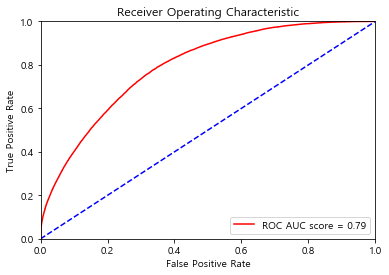

In [209]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Features importance 해석 방법
To interpret a model, we basically need to know :

which features are the most important in the model
1. the effect of each feature on a particular prediction
2. the effects of each feature over a large number of predictions
3. Native global feature importance calculations that come with XGBoostare are based on the following parameters :

Feature 
1. Weights: based on the number of times a feature appears in a tree across the ensemble of trees
2. Coverage: the average coverage (number of samples affected) of splits which use the feature
3. Gain: the average gain of splits which use the feature

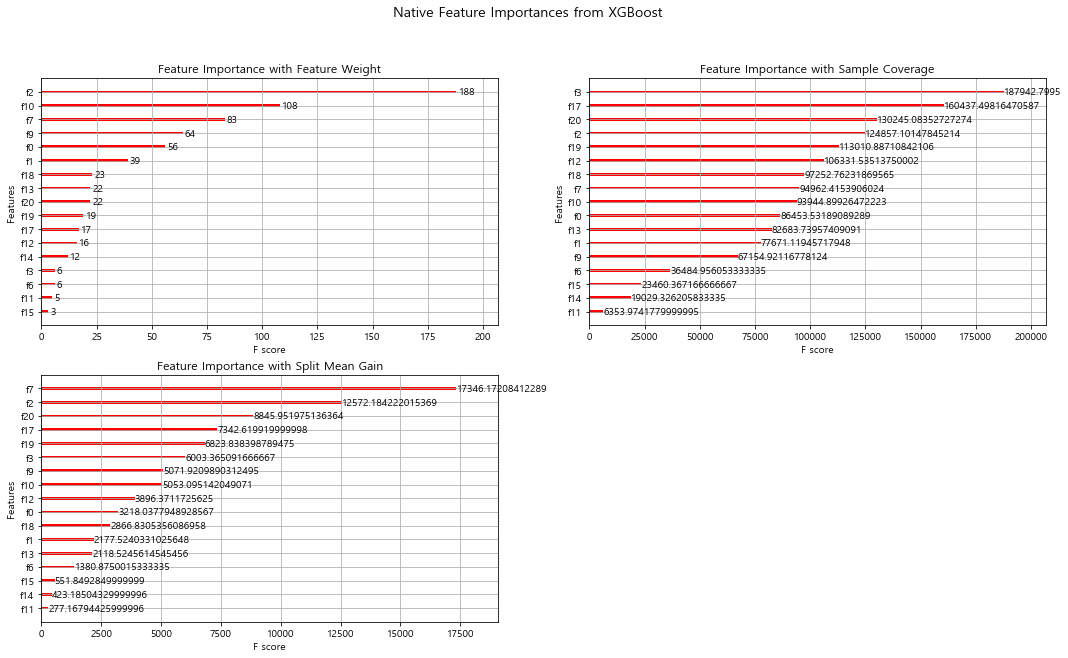

In [210]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', ax=ax2, color='red')
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='gain', ax=ax3, color='red')
ax3.set_title("Feature Importance with Split Mean Gain");

In [211]:
# feature importance
eli5.show_weights(xgb.get_booster())

Weight,Feature
0.2018,f7
0.1462,f2
0.1029,f20
0.0854,f17
0.0794,f19
0.0698,f3
0.0590,f9
0.0588,f10
0.0453,f12
0.0374,f0


In [213]:
# 0이라고 예측할 경우
# 가장 중요한 요소는 AOD,ATT,FLT 3가지로 판단됨
print('Reference:', y_test[0])
print('Predicted:', xgb_predictions[0])
eli5.show_prediction(xgb.get_booster(), X_test[0], 
                     feature_names=list(X.columns), show_feature_values=True)

Reference: 0
Predicted: 0


In [214]:
# 1이라고 예측할 경우
# 가장 중요한 요소는 AOD,ATT,FLT 3가지로 판단됨
print('Reference:', y_test[13])
print('Predicted:', xgb_predictions[13])
eli5.show_prediction(xgb.get_booster(), X_test[13], 
                     feature_names=list(X.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In [215]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

In [216]:
# PDP Plot
plot_pdp(xgb, X_resample, 'AOD')

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20'] ['SDT_MM', 'SDT_DD', 'SDT_DY', 'ARP_N', 'ODP_N', 'FLO', 'FLT', 'AOD', 'IRR', 'STT', 'ATT', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '현지기압(hPa)', '일조(hr)', '적설(cm)', '전운량(10분위)', '최저운고(100m )']
expected f1, f15, f10, f3, f20, f0, f8, f17, f19, f14, f6, f18, f16, f4, f2, f9, f11, f13, f7, f12, f5 in input data
training data did not have the following fields: 강수량(mm), FLT, 풍향(16방위), ARP_N, ATT, IRR, ODP_N, 풍속(m/s), AOD, 전운량(10분위), STT, 습도(%), SDT_MM, 현지기압(hPa), 기온(°C), SDT_DY, 일조(hr), 적설(cm), 최저운고(100m ), SDT_DD, FLO

In [ ]:
# ICE Plot
plot_pdp(xgb, X_resample, 'AOD', cluster_flag=True, nb_clusters=24, lines_flag=True)

features_to_plot = ['ATT', 'STT']
features_list = list(X.columns)

inter1  =  pdp.pdp_interact(model=xgb, dataset=X_resample, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')

# we use plot_type='grid' as the default and better option 'contour' has a bug which is being corrected
# cf. https://github.com/SauceCat/PDPbox/issues/40

plt.show()